In [1]:
! pip install statsmodels

You should consider upgrading via the 'c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('pruebillas.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [3]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from backbone.probability_transformer import ProbabilityTransformer 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from typing import Tuple
import yaml
from sklearn.metrics import classification_report
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.filters.hp_filter import hpfilter
import os
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

pd.options.display.max_rows = 999

In [4]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

def apply_cusum_filter(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

# Función para calcular la volatilidad diaria
def get_daily_volatility(close_prices, span=100):
    returns = close_prices.pct_change()
    volatility = returns.ewm(span=span).std()
    return volatility

def apply_triple_barrier(
    close_prices, 
    high_prices, 
    low_prices, 
    take_profit_in_pips, 
    stop_loss_in_pips, 
    side,
    max_holding_period=50, 
    pip_size=0.0001
    ):

    barriers = []
    for index in range(len(close_prices)):
        actual_close_price = close_prices[index]
        
        if side[index] == 1:
            # Para una señal de compra
            upper_barrier_level = round(actual_close_price + (take_profit_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (stop_loss_in_pips * pip_size), 4)
        elif side[index] == -1:
            # Para una señal de venta
            upper_barrier_level = round(actual_close_price + (stop_loss_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (take_profit_in_pips * pip_size), 4)
        else:
            # Si no hay señal, saltar al siguiente índice
            continue
        
        # Evaluar los precios futuros dentro del período máximo de mantenimiento
        for j in range(index + 1, min(index + max_holding_period, len(close_prices))):
            future_close_price = close_prices[j]
            future_high_price = high_prices[j]
            future_low_price = low_prices[j]
            
            if side[index] == 1:

                if future_low_price <= lower_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break

                elif future_high_price >= upper_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

            elif side[index] == -1:
                # Señal de venta: tomar ganancias si se alcanza la barrera inferior

                if future_high_price >= upper_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break

                elif future_low_price <= lower_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

        else:
            barriers.append((index, 2))  # Etiqueta 2 si no se alcanza ninguna barrera
    
    # # Revisar los eventos etiquetados como 2 para determinar si son ganancias o pérdidas
    # for idx, (event_index, label) in enumerate(barriers):
    #     if label == 2:
    #         # Determinar si el precio final fue una ganancia o una pérdida
    #         final_price = close_prices[min(event_index + max_holding_period, len(close_prices) - 1)]
    #         initial_price = close_prices[event_index]
            
    #         if side[event_index] == 1:
    #             # Para una señal de compra
    #             if final_price >= initial_price:
    #                 barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
    #             elif final_price < initial_price:
    #                 barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss
    #         elif side[event_index] == -1:
    #             # Para una señal de venta
    #             if final_price <= initial_price:
    #                 barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
    #             elif final_price > initial_price:
    #                 barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss

    return barriers



def triple_barrier_labeling(
        close_prices, 
        high_prices, 
        low_prices, 
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period=50, 
        pip_size=0.0001,
    ):

    labels = apply_triple_barrier(
        close_prices,
        high_prices, 
        low_prices, 
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period, 
        pip_size
    )
    
    target = [label for _, label in labels]
    return target


In [32]:
def bband_sell_stgy(prices_with_indicators, window):
    df = prices_with_indicators.copy()
    
    df['bband_flag'] = 0
    df['bband_flag'] = np.where((df['Close'] > df['upper_bband']), -1, df['bband_flag']) 
    df['bband_flag'] = np.where((df['Close'] < df['lower_bband']), 1, df['bband_flag']) 

    df['bband_distance_flag'] = 0
    df['bband_distance_flag'] = np.where((df['distance_between_bbands'] > 80), 1, df['bband_distance_flag']) 

    # Bband Flag
    df['bband_flag_negative_window'] = df['bband_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).all() else 0, raw=True)
    df['bband_distance_flag_window'] = df['bband_distance_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).all() else 0, raw=True)

    amount_conditions = 3

    short_signals = (
        (df['bband_flag_negative_window'].shift(1) == 1).astype(int) +
        (df['Close'] < df['Open']).astype(int) +
        ((df['Open'] - df['Close']) / 0.0001 > 15).astype(int) +
        (df['bband_distance_flag_window'] == 1).astype(int)
    ) >= amount_conditions

    df.loc[short_signals, 'side'] = -1

    df.dropna(inplace=True)
    return df

In [33]:
symbols_path = './backbone/data/backtest/symbols/EURUSD.csv'
df = pd.read_csv(symbols_path)
df = df[['Date','Close','High','Low','Open', 'upper_bband','lower_bband','macdhist','rsi', 'adx','mfi', 'sma_12', 'sma_26', 'distance_between_bbands']]
print('Creando target')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date')

instrument = df.copy()
# compute bband sides

instrument['side'] = np.nan

window = 4
instrument = bband_sell_stgy(instrument, window)

instrument.dropna(inplace=True)

Creando target


In [ ]:
sl = 5
rr = 2
holding_period = 12

instrument['target'] = triple_barrier_labeling(
    close_prices=instrument['Close'], 
    high_prices=instrument['High'], 
    low_prices=instrument['Low'], 
    stop_loss_in_pips=sl, 
    take_profit_in_pips=sl * rr, 
    max_holding_period=holding_period, 
    pip_size=0.001,
    side=instrument['side']
)

df.loc[instrument.index, 'side'] = instrument.side
df.loc[instrument.index, 'target'] = instrument.target
df.fillna(0, inplace=True)
# df.reset_index(inplace=True)


# Aplicar la lógica para mantener solo un 1 o -1 por cada secuencia de 1s o -1s consecutivos
df['side'] = df['side'].where(
    (df['side'] == 0) | (df['side'] != df['side'].shift(1)),
    0
)


df['target'] = np.where(df['side'] != 0, df['target'], 0)

display(pd.DataFrame(df[df.side!=0].groupby(by=['side','target'])['target'].count()))



df['dummy_model_pred'] = 1
print(classification_report(df[df.side != 0].target, df[df.side != 0].dummy_model_pred))

In [20]:
df = df.reset_index()

In [9]:
from matplotlib import pyplot as plt

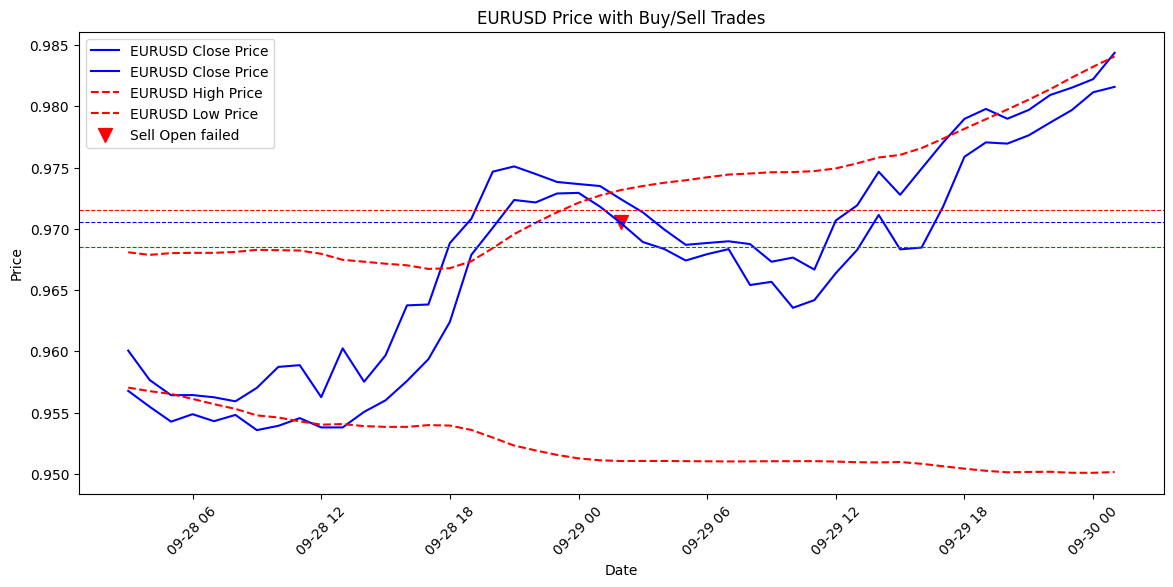

KeyboardInterrupt: Interrupted by user

In [10]:
ticker = 'EURUSD'

orders = df[df.side != 0]
for index, order in orders.iterrows():

    date_from = order.Date - timedelta(hours=24)
    date_to = order.Date + timedelta(hours=24)
    
    date_from_str = date_from.strftime('%Y-%m-%d-%H')
    date_to_str = date_to.strftime('%Y-%m-%d-%H')

    historical_prices = df[
        (df['Date']>date_from_str)
        & (df['Date']<date_to_str)
    ]
    

    plt.figure(figsize=(14, 6))
    plt.plot(historical_prices['Date'], historical_prices['High'], label=f'{ticker} Close Price', color='blue')
    plt.plot(historical_prices['Date'], historical_prices['Low'], label=f'{ticker} Close Price', color='blue')
    plt.plot(historical_prices['Date'], historical_prices['upper_bband'], '--r', label=f'{ticker} High Price')
    plt.plot(historical_prices['Date'], historical_prices['lower_bband'], '--r', label=f'{ticker} Low Price')

    plt.axhline(order.Close, color='blue', linewidth=0.8, linestyle='--')

    order_result = ''
    if order.target == 1:
        order_result = 'success' 
    if order.target == 0:
        order_result = 'failed'
    if order.target == 2:
        order_result = 'days'

    stop_loss = None
    take_profit = None

    if order.side == 1:
        stop_loss = order.Close - (0.0001 * sl)
        take_profit = order.Close + (0.0001 * sl * rr)
        plt.scatter([str(order.Date)], [order.Close], color='green', marker='^', s=100, label=f'Buy Open {order_result}')
    else:
        stop_loss = order.Close + (0.0001 * sl)
        take_profit = order.Close - (0.0001 * sl * rr)
        plt.scatter([str(order.Date)], [order.Close], color='red', marker='v', s=100, label=f'Sell Open {order_result}')
    
    plt.axhline(stop_loss, color='red', linewidth=0.8, linestyle='--')
    plt.axhline(take_profit, color='green', linewidth=0.8, linestyle='--')
    
    # Añadir etiquetas y leyenda
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Price with Buy/Sell Trades')
    plt.legend()
    plt.xticks(rotation=45)

    # Mostrar el gráfico
    plt.show()
    
    # print(date_from_str, date_to_str)
   
    a = input()
    
    clear_output()


In [ ]:
df['Date'] = df['Date'].dt.to_period('M')
df[df.side != 0].groupby(by=['Date','side','target'])[['target']].count()

In [ ]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['hour'] = df.Date.dt.hour

df[df.side!=0].groupby(['year','month','day'])['side'].count()



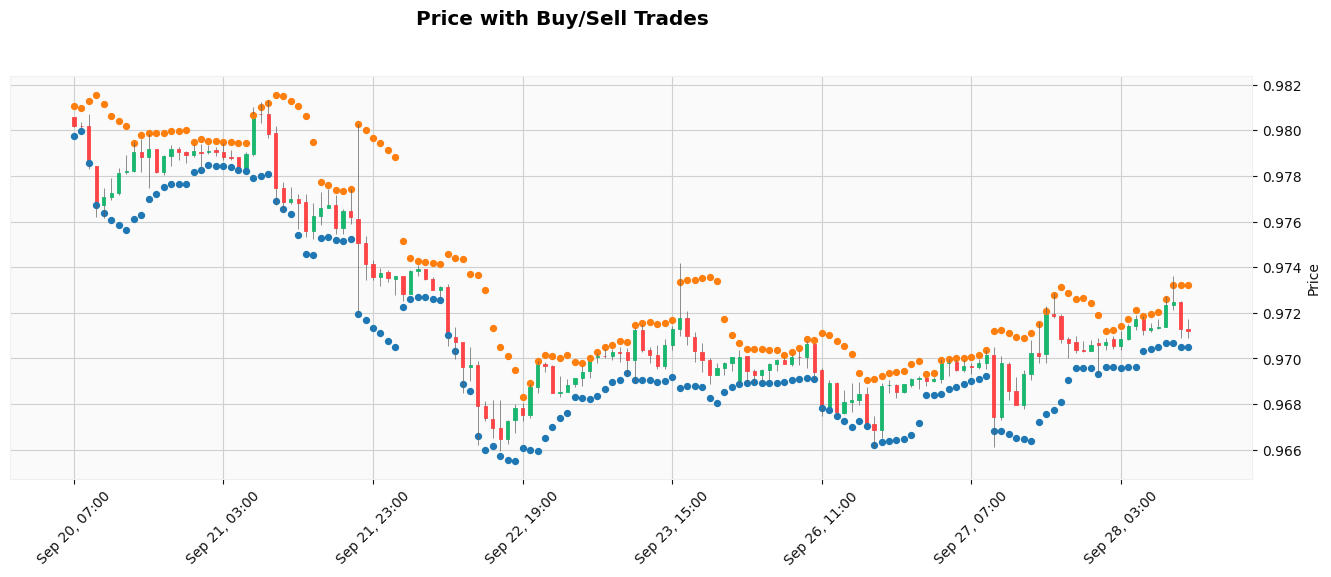

In [22]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import timedelta

symbols_path = './backbone/data/backtest/symbols/USDCHF.csv'
historical_prices = pd.read_csv(symbols_path, nrows=150)

historical_prices['Date'] = pd.to_datetime(historical_prices['Date'])

historical_prices.set_index('Date', inplace=True)

resistances = mpf.make_addplot(historical_prices['r1'], type='scatter')
supports = mpf.make_addplot(historical_prices['s1'], type='scatter')

# Crear las listas de anotaciones inicializadas con NaN
fig, axlist = mpf.plot(
    historical_prices, 
    type='candle', 
    style='yahoo', 
    returnfig=True, 
    volume=False, 
    title='Price with Buy/Sell Trades', 
    figratio=(15,5),
    addplot=[supports, resistances]
)


# Añadir etiquetas y leyenda
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.xticks(rotation=45)

plt.show()


In [ ]:
# import pandas as pd
# import os
# pd.set_option('display.max_columns', None)

# periods_forward = 5

# tickers = ['EURUSD']
# symbols_path = './backbone/data/backtest/symbols'
# instruments = {}
# df = pd.DataFrame()

# for ticker in tickers:
#     instruments[ticker] = pd.read_csv(os.path.join(symbols_path, f'{ticker}.csv'))
  
#     instruments[ticker]['ticker'] = ticker
  
#     print('Creando target')
   
#     instruments[ticker] = instruments[ticker].sort_values(by='Date')

#     instruments[ticker]['target'] = triple_barrier_labeling(instruments[ticker], upper_barrier=0.015, lower_barrier=0.015, max_holding_period=48, span=100)
    
#     df = pd.concat([
#         df,
#         instruments[ticker]
#     ])

#     df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:00:00')

#     df = df.sort_values(by='Date')

In [ ]:
date_format = '%Y-%m-%d %H:00:00'
window = 11520

actual_date = datetime(2023,1,1,0,0,0)

date_to = actual_date - timedelta(hours=24+1) 
date_from = date_to - timedelta(hours=window)

date_from_test = actual_date
date_to_test = date_from_test + timedelta(hours=1440)

date_from_str = date_from.strftime(date_format)
date_to_str = date_to.strftime(date_format)
date_from_test_str = date_from_test.strftime(date_format)
date_to_test_str = date_to_test.strftime(date_format)


train = df[(df['Date']>date_from_str) & (df['Date']<date_to_str) & (df.side != 0)]
test = df[(df['Date']>date_from_test_str) & (df['Date']<date_to_test_str) & (df.side != 0)]

train.target.value_counts()

In [ ]:
test.target.value_counts()

In [ ]:
from backbone.machine_learning_agent import MachineLearningAgent

with open('./configs/model_config.yml', 'r') as file:
    model_configs = yaml.safe_load(file)

cols_to_drop = [
  'Open',
  'High',
  'Low',
  'Close',
  'target', 
  'Date', 
  # 'ticker'
]

model_name = 'gradient_boosting'

param_grid = model_configs[model_name]['param_grid']
model = model_configs[model_name]['model']

mla = MachineLearningAgent(
    tickers=['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF'], 
    model=model, 
    param_grid=param_grid
)

In [ ]:
x_train = train.drop(columns=cols_to_drop)
y_train = train.target

In [ ]:
y_train.value_counts()

In [ ]:
mla.train(
    x_train = train.drop(columns=cols_to_drop),
    x_test = test.drop(columns=cols_to_drop),
    y_train = train.target,
    y_test = test.target,
    date_train=actual_date,
    verbose=True,
    undersampling=False
)

# Train performance

In [ ]:
classes, probas = mla.predict_proba(train.drop(columns=cols_to_drop))

precision = precision_score(train.target, classes, average='weighted')
recall = recall_score(train.target, classes, average='weighted')
f1 = f1_score(train.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

print(classification_report(train.target, classes))

# Test performance

In [ ]:
classes, probas = mla.predict_proba(test.drop(columns=cols_to_drop))

precision = precision_score(test.target, classes, average='weighted')
recall = recall_score(test.target, classes, average='weighted')
f1 = f1_score(test.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, classes))

In [ ]:
binary_probas = np.where(classes == 0, 1-probas, probas)
binary_probas

In [ ]:
test['pred_label'] = np.nan
test['proba'] = np.nan

cols_to_drop += ['pred_label', 'proba']
side = (test.side != 0).any()

for index, stock in test.iterrows():
  
  if side:
      # Drop the specified columns before prediction
      stock_features = stock.drop(labels=cols_to_drop)
      
      stock_features_df = pd.DataFrame([stock_features])

      # Predict the class and probability
      _class, proba = mla.predict_proba(stock_features_df)
      
      # Assign the predicted class and probability to the DataFrame
      test.at[index, 'pred_label'] = _class
      test.at[index, 'proba'] = proba


In [ ]:
precision = precision_score(test.target, test.pred_label, average='weighted')
recall = recall_score(test.target, test.pred_label, average='weighted')
f1 = f1_score(test.target, test.pred_label, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, test.pred_label))

In [ ]:
test_results = {}
test_results['EURUSD'] = {}
test_results['USDJPY'] = {}
test_results['USDCAD'] = {}
test_results['EURUSD']['2021-01-01']={}
test_results['USDJPY']['2021-01-01']={}
test_results['USDCAD']['2021-01-01']={}

test_results['EURUSD']['2021-01-02']={}
test_results['USDJPY']['2021-01-02']={}
test_results['USDCAD']['2021-01-02']={}

In [ ]:
test_results['EURUSD']['2021-01-01']['y_true'] = 1
test_results['EURUSD']['2021-01-01']['y_pred'] = 0
test_results['EURUSD']['2021-01-01']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-01']['y_true'] = 1
test_results['USDJPY']['2021-01-01']['y_pred'] = 0
test_results['USDJPY']['2021-01-01']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-01']['y_true'] = 1
test_results['USDCAD']['2021-01-01']['y_pred'] = 0
test_results['USDCAD']['2021-01-01']['y_proba'] = 0.2

test_results['EURUSD']['2021-01-02']['y_true'] = 1
test_results['EURUSD']['2021-01-02']['y_pred'] = 0
test_results['EURUSD']['2021-01-02']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-02']['y_true'] = 1
test_results['USDJPY']['2021-01-02']['y_pred'] = 0
test_results['USDJPY']['2021-01-02']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-02']['y_true'] = 1
test_results['USDCAD']['2021-01-02']['y_pred'] = 0
test_results['USDCAD']['2021-01-02']['y_proba'] = 0.2

In [ ]:
test_results

In [ ]:
df_results = pd.DataFrame()

for ticker, values in test_results.items():
    for date, values2 in values.items():
        single_line_df = pd.DataFrame(
            {
                'ticker':[ticker], 
                'date':[date], 
                'y_true':values2['y_true'], 
                'y_pred':values2['y_pred'], 
                'proba':values2['y_proba'],
            }
        )

        df_results = pd.concat([df_results, single_line_df])

df_results
           

In [ ]:
df

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

df = pd.read_csv('./backbone/data/trading/symbols/dataset.csv')


for ticker in df.ticker.unique():
    print(ticker)
    df_ticker = df[df['ticker']==ticker].tail(48)
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Datos de ejemplo
    x = pd.to_datetime(df_ticker['Date'])
    trend = df_ticker['trend']  # Datos para la línea
    sma20 = df_ticker['SMA20']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x, trend, label='trend')
    ax.plot(x, sma20, label='sma20')
        
    ax.legend()
        
        # Mostrar el gráfico
        # print(path)
    plt.show()
    a = input()
    
    clear_output(wait=True)

In [ ]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

In [ ]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

In [ ]:
df.side.

In [ ]:
import MetaTrader5 as mt5
from datetime import datetime

In [ ]:


# Iniciar sesión en la plataforma MetaTrader 5
if not mt5.initialize():
    print("Failed to initialize MT5, error code =", mt5.last_error())
    quit()

# Definir los parámetros de la orden
order_id = 2645992483  # ID de la orden que deseas modificar
new_stop_loss = 1.12345  # Nuevo precio de stop loss

# Obtener la orden existente
order = mt5.positions_get(ticket=order_id)
if order is None:
    print("Failed to get order, error code =", mt5.last_error())
    mt5.shutdown()
    quit()

In [ ]:
order = order[0]


In [ ]:
order

In [ ]:
# Definir los parámetros para la modificación de la orden
request = {
    "action": mt5.TRADE_ACTION_SLTP,
    "position": order_id,
    "sl": new_stop_loss,
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_RETURN,
}



# Enviar la solicitud para modificar la orden
result = mt5.order_send(request)
if result.retcode != mt5.TRADE_RETCODE_DONE:
    print(f"Failed to modify order, error code: {result.retcode}")
else:
    print("Order modified successfully")

# Cerrar la conexión con la plataforma MetaTrader 5


In [ ]:
result

In [ ]:
from datetime import datetime
import MetaTrader5 as mt5
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
 
# import the 'pandas' module for displaying data obtained in the tabular form
import pandas as pd
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
# import pytz module for working with time zone
import pytz
 
# establish connection to MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(2020, 1, 1, tzinfo=timezone)
utc_to = datetime(2021, 1, 1, tzinfo=timezone)
# request AUDUSD ticks within 11.01.2020 - 11.01.2020
ticks = mt5.copy_ticks_range("AUDUSD", utc_from, utc_to, mt5.COPY_TICKS_ALL)
print("Ticks received:",len(ticks))
 
# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()
 
 
# create DataFrame out of the obtained data
ticks_frame = pd.DataFrame(ticks)
# convert time in seconds into the datetime format
ticks_frame['time']=pd.to_datetime(ticks_frame['time'], unit='s')
 
# display data
ticks_frame.head(10)

In [ ]:
ticks_frame

In [ ]:
import pandas as pd

In [ ]:
symbols_path = './backbone/data/backtest/symbols/EURUSD.csv'
df = pd.read_csv(symbols_path)
df = df[['Date','Close','High','Low','Open']]
df

In [ ]:
def diff_pips(price1, price2, pip_value, absolute=True):
    if absolute:
        difference = abs(price1 - price2)
    else:
        difference = price1 - price2
    pips = difference / pip_value
    return pips

In [ ]:
pip_value = 0.0001
df['pip_distance_co'] = df.apply(lambda row: diff_pips(row['Close'], row['Open'], pip_value=pip_value, absolute=False), axis=1)

In [ ]:
df['pip_distance_cc1'] = df.apply(lambda df: diff_pips(df['Close'], df['Close'].shift(1), pip_value=pip_value, absolute=False))
df